# Health study report
Magdalena Persson

### För G ska du göra:
**Strukturera koden**
- Flytta delar av din kod från del 1 till funktioner och moduler.
- Skapa minst en klass (t.ex. HealthAnalyzer) som kan utföra någon del av analysen (t.ex. beräkna statistik eller rita grafer).  

**Linjär algebra i praktiken**
- Använd numpy eller scikit-learn för en analys som bygger på matriser/vektorer.  
*Exempel:*
- En enkel linjär regression för att förutsäga blodtryck från ålder och vikt.
- PCA för att hitta mönster i datan.  

**Utökad analys och visualisering**
- Lägg till minst en ny analys eller graf som ger en djupare förståelse (t.ex. relationen mellan blodtryck och ålder, eller sjukdomsförekomst per kön).  

**Dokumentation**
- Skriv docstrings till dina funktioner/klasser.
- Använd markdown-rutor för att förklara vad du gör och varför.

**För VG ska du även göra:**
Bygg en mer utvecklad klass som kan hantera flera olika analyser eller visualiseringar.
Använd en mer avancerad metod (t.ex. multipel regression) eller en extra visualisering som tydligt förklarar resultaten.
Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.

In [611]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from scipy.stats import ttest_ind

REQUIRED = [
    "id", "age", "sex", "height", "weight", "systolic_bp", "cholesterol", "smoker", "disease"
]

def load_data(path: str) -> pd.DataFrame:
    """
    Läser CSV och kontrollerar att alla kolumner som listas i "REQUIRED" finns med.
    """
    df = pd.read_csv("data/health_study_dataset.csv")
    missing = [c for c in REQUIRED if c not in df.columns]
    if missing:
        raise ValueError(f"Saknade kolumner: {missing}")
    return df

def coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """
    Säkerställer att numeriska kolumner faktiskt är numeriska.
    """
    out = df.copy()
    for c in ["age", "height", "systolic_bp", "cholesterol", "disease"]:
        out [c] = pd.to_numeric(out[c], errors="coerce")
    return out


In [612]:
df = load_data("data/health_study_dataset.csv")
df = coerce_numeric(df)

print(df.isna().sum()) # kontrollera så det inte finns några NaN-värde

id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64


In [613]:
columns = ["age", "weight", "height", "systolic_bp", "cholesterol"]

summary = pd.DataFrame ({
    "mean": df[columns].mean(),
    "median": df[columns].median(),
    "min": df[columns].min(),
    "max": df[columns].max()
})

print("Medel, median, min och max för utvalda kategorier:")
display(summary)


Medel, median, min och max för utvalda kategorier:


,mean,median,min,max
age,49.426250,50.00,18.0,90.00
weight,73.413000,73.20,33.7,114.40
height,171.849250,171.35,144.4,200.40
systolic_bp,149.178625,149.40,106.8,185.90
cholesterol,4.929150,4.97,2.5,7.88


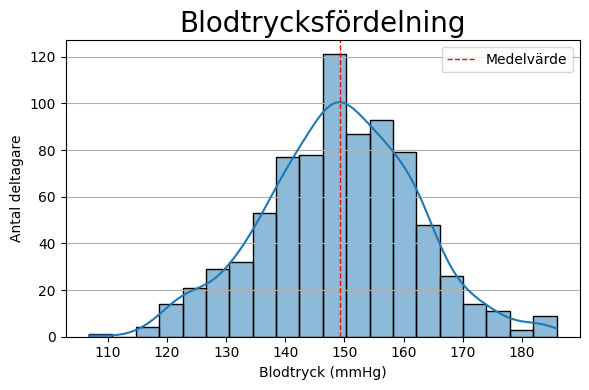

In [614]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(df["systolic_bp"], bins=20, edgecolor="black", ax=ax, kde=True)
ax.axvline((df["systolic_bp"]).mean(), color="red", linestyle="--", linewidth="1", label="Medelvärde")
ax.set_title("Blodtrycksfördelning", fontsize=20)
ax.set_xlabel("Blodtryck (mmHg)")
ax.set_ylabel("Antal deltagare")
ax.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

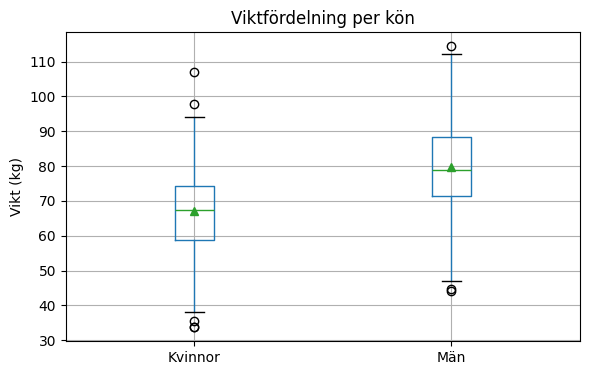

In [615]:
fig, ax = plt.subplots(figsize=(6, 4))
df.boxplot(column="weight", by="sex", ax=ax, showmeans=True)
ax.set_title("Viktfördelning per kön")
ax.set_xlabel("")
ax.set_ylabel("Vikt (kg)")
ax.set_xticklabels(["Kvinnor", "Män"])
plt.suptitle("") 
plt.tight_layout()
plt.show()


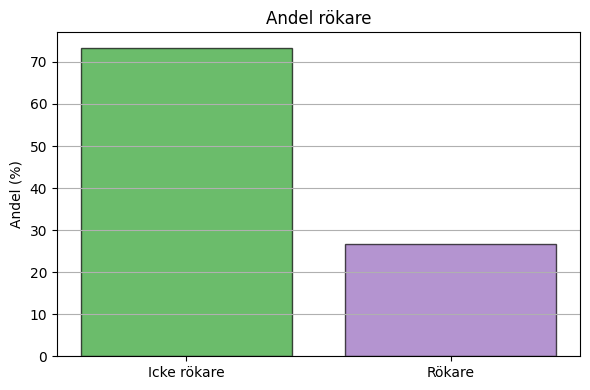

In [616]:
smoker_count = df["smoker"].value_counts(normalize=True)*100

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(smoker_count.index.astype(str), smoker_count.values, alpha=0.7, edgecolor="black", color=["tab:green", "tab:purple"])
ax.set_title("Andel rökare")
ax.set_xlabel("")
ax.set_ylabel("Andel (%)")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Icke rökare", "Rökare"])
ax.grid(True, axis="y")
plt.tight_layout()
plt.show;

In [617]:
sick = df[df["disease"] == 1]
sick = sick.value_counts().sum()

total = len(df)

sick_percent = sick / total * 100

In [618]:
np.random.seed(42)

In [619]:
n = 1000
w_disease = sick / total

sim = np.random.choice([0, 1], size=n, p=[1 - w_disease, w_disease])
sim_mean = sim.mean() * 100

print(f"Antalet med sjukdomen är: {sick} st dvs {sick_percent:.2f}% av deltagarna")
print(f"Med simulation blir andelen sjuka {sim_mean:.2f}%")

Antalet med sjukdomen är: 47 st dvs 5.88% av deltagarna
Med simulation blir andelen sjuka 5.60%


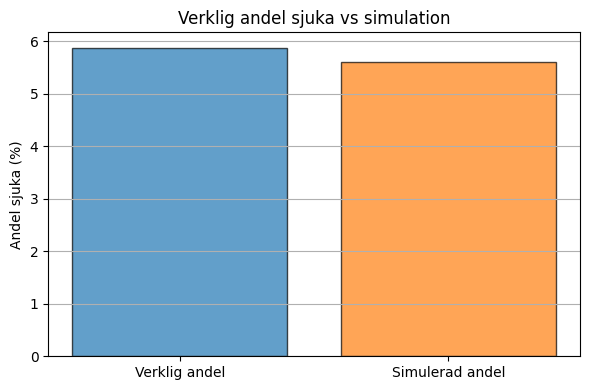

In [620]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(["Verklig andel", "Simulerad andel"], [sick_percent, sim_mean], alpha=0.7, edgecolor="black", color=["tab:blue", "tab:orange"])
ax.set_title("Verklig andel sjuka vs simulation")
ax.set_xlabel("")
ax.set_ylabel("Andel sjuka (%)")
ax.grid(True, axis="y")
plt.tight_layout()
plt.show;

### Grafen ovan visar en jämförelse över den simulerade andelen och den verkliga andelen sjuka.
Den simulerade andelen är baserad på 1000 slumpmässigt valda personer med återläggning från datasetet.

In [621]:
x = df["systolic_bp"].dropna().to_numpy()
rng = np.random.default_rng(0)
n = len(x)
B = 5000

b_means = np.array([x[rng.integers(0, n, size=n)].mean() for _ in range(B)])

boot_mean = np.mean(b_means)
ci_low, ci_high = np.percentile(b_means, [2.5, 97.5])

print("Konfidensintervall för blodtryck (bootstrap):")
print(f"Medel: {boot_mean:.2f}, 95% CI: {ci_low:.2f}, {ci_high:.2f}")


Konfidensintervall för blodtryck (bootstrap):
Medel: 149.18, 95% CI: 148.28, 150.06


In [622]:
x = df["systolic_bp"].dropna().to_numpy()
mean_x = x.mean()
sd = x.std(ddof=1)             
n = x.size
se = sd / np.sqrt(n)

z = 1.96
lo_norm = (mean_x - z*se) 
hi_norm = (mean_x + z*se)

print("Konfidensintervall för blodtryck (normal-approximation):")
print(f"Medel: {mean_x:.2f}, 95% CI: {lo_norm:.2f}, {hi_norm:.2f}")

Konfidensintervall för blodtryck (normal-approximation):
Medel: 149.18, 95% CI: 148.29, 150.07


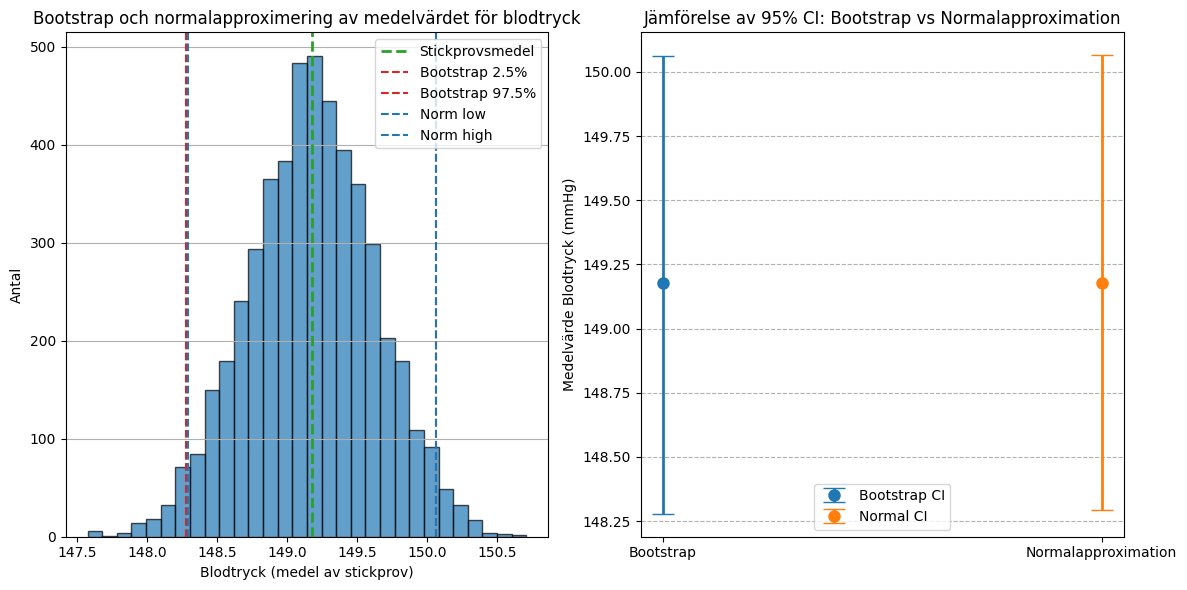

In [623]:
boot_lower = mean_x - ci_low
boot_upper = ci_high - mean_x

norm_lower = mean_x - lo_norm
norm_upper = hi_norm - mean_x

fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=False) 
axes[0].hist(b_means, bins=30, alpha=0.7, edgecolor="black")
axes[0].axvline(mean_x, color="tab:green", linestyle="--", label="Stickprovsmedel", linewidth=2)
axes[0].axvline(ci_low, color="tab:red", linestyle="--", label="Bootstrap 2.5%")
axes[0].axvline(ci_high, color="tab:red", linestyle="--", label="Bootstrap 97.5%")
axes[0].axvline(lo_norm, color="tab:blue", linestyle="--", label="Norm low")
axes[0].axvline(hi_norm, color="tab:blue", linestyle="--", label="Norm high")
axes[0].set_title("Bootstrap och normalapproximering av medelvärdet för blodtryck")
axes[0].set_xlabel("Blodtryck (medel av stickprov)")
axes[0].set_ylabel("Antal")
axes[0].grid(True, axis="y")
axes[0].legend()

axes[1].errorbar("Bootstrap", [mean_x], 
       yerr=[[boot_lower],[boot_upper]], 
       elinewidth=2, markersize=8, fmt="o", capsize=8, label="Bootstrap CI")
axes[1].errorbar("Normalapproximation", [mean_x], 
       yerr=[[norm_lower],[norm_upper]], 
       elinewidth=2, markersize=8, fmt="o", capsize=8, label="Normal CI")
axes[1].set_ylabel("Medelvärde Blodtryck (mmHg)")
axes[1].set_title("Jämförelse av 95% CI: Bootstrap vs Normalapproximation")
axes[1].grid(True, axis="y", linestyle="--")
axes[1].legend()

plt.tight_layout()
plt.show()

### Graferna ovan visar jämförelsen när konfidensintervallet för blodtryck tagits ut med Bootstrap och Normalapproximation.

Som man kan se utläser vi en väldigt liten skillnad mellan de olika metoderna, vilket innebär att man i detta fall bör använda sig av Normalapproximation.

In [624]:
s_yes = (df["smoker"] == "Yes").sum()
s_no = total - s_yes

print(f"Antal rökare är {s_yes} st och icke-rökare {s_no} st deltagare.")

smoker_stats = df.groupby("smoker")["systolic_bp"].agg(["count", "mean", "median", "std", "min", "max"])
smoker_stats


Antal rökare är 213 st och icke-rökare 587 st deltagare.


,count,mean,median,std,min,max
smoker,,,,,,
No,587,149.052981,149.3,12.626038,116.3,185.9
Yes,213,149.524883,149.5,13.267800,106.8,184.2


In [625]:
low, high = df["systolic_bp"].quantile([0.01, 0.99])
clipped = df[(df["systolic_bp"] >= low) & (df["systolic_bp"] <= high)]

compare_means = pd.DataFrame({
    "original_mean_Y": [df.loc[df.smoker == "Yes", "systolic_bp"].mean()],
    "original_mean_N": [df.loc[df.smoker == "No", "systolic_bp"].mean()],
    "clipped_mean_Y": [clipped.loc[clipped.smoker == "Yes", "systolic_bp"].mean()],
    "clipped_mean_N": [clipped.loc[clipped.smoker == "No", "systolic_bp"].mean()]
})

compare_means

,original_mean_Y,original_mean_N,clipped_mean_Y,clipped_mean_N
0,149.524883,149.052981,149.194634,149.145423


In [626]:
s_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"].dropna().to_numpy()
s_no = df.loc[df["smoker"] == "No", "systolic_bp"].dropna().to_numpy()

n_boot = 5000
obs_diff = s_yes.mean() - s_no.mean()

boot_diffs = np.empty(n_boot) 
for i in range(n_boot):
    s1 = np.random.choice(s_yes, size=len(s_yes), replace=True)
    s2 = np.random.choice(s_no, size=len(s_yes), replace=True)
    boot_diffs[i] = s1.mean() - s2.mean()

p_boot = np.mean(np.abs(boot_diffs) >= abs(obs_diff)) # beräknat bootstrap p-andel

ci_low, ci_high = np.percentile(boot_diffs, [2.5, 97.5])

print(f"Observerad skillnad mellan rökare och icke-rökare: {obs_diff:.2f} mmHg")
print(f"95% konfidensintervall: [{ci_low:.2f}, {ci_high:.2f}]")
print(f"Bootstrap p-värde: {p_boot:.4f}")

Observerad skillnad mellan rökare och icke-rökare: 0.47 mmHg
95% konfidensintervall: [-2.03, 2.86]
Bootstrap p-värde: 0.7250


In [627]:
t_stat, p_val= stats.ttest_ind(s_no, s_yes, equal_var=False)

print(f"Welch t-test: t = {t_stat:.2f}, p = {p_val:.2}")

Welch t-test: t = -0.45, p = 0.65


In [628]:
rng = np.random.default_rng()

mean_no = s_no.mean()
mean_yes = s_yes.mean()
std_no = s_no.std(ddof=1)
std_yes = s_yes.std(ddof=1)

def estimate_power_by_simulation(n_no, n_yes, mean_no, mean_yes, std_no, std_yes, alpha=0.05, num_simulations=5000):
    
    rejections = 0

    for _ in range(num_simulations):
       
        x = rng.normal(loc=mean_no, scale=std_no, size=n_no)
        y = rng.normal(loc=mean_yes, scale=std_yes, size=n_yes)

        _, pval = stats.ttest_ind(x, y, equal_var=False)

        if pval < alpha:
            rejections += 1

    return rejections / num_simulations

power = estimate_power_by_simulation(
    n_no=len(s_no),
    n_yes=len(s_yes),
    mean_no=s_no.mean(),
    mean_yes=s_yes.mean(),
    std_no=s_no.std(ddof=1),
    std_yes=s_yes.std(ddof=1),
)

print("Power ->", power)



Power -> 0.0784


### Hypotes: ”Rökare har högre medel-blodtryck än icke-rökare.”

- Den observerade skillnaden mellan rökare och icke rökare, där rökare har 0.47 mmHg högre blodtryck, är väldigt liten.
- P-värdet är uttaget via två olika test, bootstrap och t-test och visar högt vilket betyder att slumpen kan ha orsakat. Nollhypotesen kan ej förkastas i detta fall.
- Då 0 ligger inom konfidensintervallet finns det inget statistiskt stöd och man kan inte utesluta att den sanna skillnaden är 0.
- Power på ca 7% visar att testet har mycket låg känslighet och missar skillnaden i de flesta simuleringar.

### Slutsats:
- Man behöver mer data för att se om det finns någon verklig skillnad på blodtrycket mellan rökare och icke rökare. 

### Dokumentation


- För information om t-test användes:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

- Power:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.power.html#scipy.stats.power

- Videolektioner v.6 och v.7.
